# **OpenAlex Project**

In this notebook, I apply the the Pyalex Module to scrap data from OpenAlex repository of Academic Journals. I build a pipeline to extract journals containing several AI-related kewyords, with the aim of analysing the evolution in sociology / political science fields.

In [ ]:
!pip install pyalex pandas

Importing the required packages

In [ ]:
import re
import time
import pandas as pd
import numpy as np
from pyalex import Works, Sources
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import plotly.graph_objects as go

## **1. Data collection from OpenAlex Repository**

### **Helpers Functions**

#### **1. Understanding OpenAlex Abstract Storage (Inverted Index)**

OpenAlex does not store abstracts as plain text.
Instead, it uses a compressed format called an inverted index to reduce storage size.

In this structure:

- Each key is a word that appears in the abstract.
- Each value is a list of positions indicating where that word appears in the original text.

Example:

```json
"abstract_inverted_index": {
  "climate": [0, 6],
  "change": [1],
  "impacts": [2],
  "on": [3],
  "biodiversity": [4, 5]
}
```

This means that `climate` appears at positions 0 and 6, `change` is at position 1, `biodiversity` appears twice, at positions 4 and, and so on.

Because OpenAlex only provides this compressed index, the abstract must be reconstructed manually.

The helper function `decompress_abstract()` included in this notebook:

1. Determines the full abstract length based on the highest position.
2. Creates an empty list with one entry per word position.
3. Inserts each word into its correct position.
4. Joins the ordered words into a readable abstract string.

In [ ]:
# ---------------------------------------------
# 1. Rebuild abstract from OpenAlex inverted index
# ---------------------------------------------
def decompress_abstract(inverted_index: dict) -> str:
    if inverted_index is None:
        return None

    max_pos = max(max(positions) for positions in inverted_index.values())
    words = [""] * (max_pos + 1) # create a list with the size of the abstract

    for word, positions in inverted_index.items():
        for pos in positions:
            words[pos] = word

    return " ".join(words)

#### **2. Extracting keywords matching in Abstracts**

Substring-based keyword searches may produce matches where a keyword appears as part of a longer word, such as detecting “AI” within “fairness” or “email”. To address this, keyword matching is performed using regular expressions that allow matching at the word level.

This helper function:

* Accepts a pre-defined regular expression as the keyword pattern.
* Applies case-sensitive matching for selected acronyms (e.g., AI, LLM, GPT).
* Uses case-insensitive matching for other keywords.
* Executes the search using regular expression matching and returns False if the pattern is invalid.

This procedure supports consistent keyword detection in reconstructed OpenAlex abstracts.

In [ ]:
# ---------------------------------------------
# 2. Strict keyword matching in abstract
# ---------------------------------------------
ACRONYM_PATTERNS = {
    r"\bLLM(s)?\b",
    r"\bGPT\b",
    r"\bBERT\b",
    r"\bLSTM\b",
    r"\bAI\b",
}

def keyword_in_abstract_strict(query_label: str, abstract: str) -> bool:
    if not abstract or not query_label:
        return False
    # Acronyms are matched case-sensitively; other keywords are case-insensitive
    flags = 0 if query_label in ACRONYM_PATTERNS else re.IGNORECASE

    try:
        return re.search(query_label, abstract, flags=flags) is not None
    except re.error:
        return False

#### **3. Find journal in OpenAlex by ISSN or name**

This helper attempts to identify a journal in OpenAlex using available ISSN information and, if no ISSN match is found, performs a name-based search. It returns the OpenAlex journal identifier, the journal display name, and the ISSN that produced the match when applicable. If no journal is identified, all returned values are `None`

In [ ]:
# ---------------------------------------------
# 3. Find journal in OpenAlex by ISSN or name
# ---------------------------------------------
def get_journal_id_by_issn_or_name(journal_name, issn_field):
    """
    Returns: (openalex_id, display_name, matched_issn)
    Tries ISSN first, then journal name.
    """
    # Try ISSNs if available
    if pd.notna(issn_field) and issn_field not in ["", "nan", "NaN"]:
        issns = [i.strip() for i in str(issn_field).split(",")]
        for issn in issns:
            if not issn:
                continue
            results = Sources().filter(issn=issn).get()
            if results:
                best = results[0]
                return best["id"], best["display_name"], issn

    # Fallback: search by journal name
    results = Sources().search(journal_name).get()
    if results:
        best = results[0]
        return best["id"], best["display_name"], None

    return None, None, None

#### **4. Retrieve works for a journal published since 2010**

For each matched journal, all works published from 2010 onwards are retrieved using the OpenAlex API. The helper function `get_all_works_since_2010()` filters works by the journal’s OpenAlex identifier and by publication date, and uses pagination to iterate through all available result pages. The output is a list of works associated with the journal.

The helper function `total_articles_journal_per_year()` aggregates a list of works by publication year for a given journal. It returns a DataFrame containing the journal name, publication year, and the total number of articles published in each year.

In [ ]:
# ---------------------------------------------
# 4. Download ALL works for a journal since 2010
# ---------------------------------------------
from typing import List, Dict
import pandas as pd

def get_all_works_since_2010(journal_id: str) -> List[Dict]:
    """
    Retrieve all OpenAlex works associated with a given journal
    published from 2010 onwards.

    The query filters works by the journal OpenAlex identifier and
    applies pagination to iterate through all available result pages.

    Returns:
        List[Dict]: List of OpenAlex works, each represented as a dictionary.
    """
    works_pages = (
        Works()
        .filter(
            locations={"source": {"id": journal_id}},
            from_publication_date="2010-01-01"
        )
        .paginate(per_page=200)
    )

    all_works: List[Dict] = []
    for page in works_pages:
        # Each page contains a list of works
        all_works.extend(page)

    return all_works


def total_articles_journal_per_year(
    works: List[Dict],
    journal_name: str
) -> pd.DataFrame:
    """
    Aggregate the total number of works per publication year for a journal.

    Works without a publication year are excluded from the aggregation.

    Returns:
        pd.DataFrame: DataFrame with columns
            - journal_input
            - year
            - n_articles_total
    """
    rows: List[Dict] = []

    for w in works:
        year = w.get("publication_year")
        if year is None:
            continue

        rows.append({
            "journal_input": journal_name,
            "year": int(year)
        })

    if not rows:
        return pd.DataFrame(
            columns=["journal_input", "year", "n_articles_total"]
        )

    return (
        pd.DataFrame(rows)
        .groupby(["journal_input", "year"])
        .size()
        .reset_index(name="n_articles_total")
    )

#### **5. Extract metadata from a single work**

This helper extracts selected metadata fields from a single OpenAlex work, including the DOI, publication year, title, journal name, and authors. The abstract is reconstructed from the OpenAlex inverted index representation using the `decompress_abstract` helper function. Keyword presence in the abstract is then evaluated using the `keyword_in_abstract_strict` helper, which returns a boolean indicating whether the specified keyword appears in the reconstructed abstract. The output is a dictionary containing the extracted metadata, the reconstructed abstract, and the keyword match result.

In [ ]:
# ---------------------------------------------
# 5. Extract metadata from a single work
# ---------------------------------------------
def extract_metadata(work: dict, journal_label: str, query_label: str) -> dict:
    """
    Extract selected metadata fields from a single OpenAlex work.
    Reconstruct the abstract and check whether the keyword appears
    as a full word in the abstract.
    """

    doi = work.get("doi")
    year = work.get("publication_year")
    title = work.get("title")

    # Extract journal name from locations
    journal = None    # journal name as in OpenAlex
    locations = work.get("locations") or []
    for loc in locations:
        src = loc.get("source")
        if src and src.get("display_name"):
            journal = src["display_name"]
            break

    # Extract authors safely (avoid None)
    authors_raw = work.get("authorships", [])
    authors = []
    for auth in authors_raw:
        author_dict = auth.get("author", {}) or {}
        name = author_dict.get("display_name")
        if isinstance(name, str):   # Only accept valid strings
            authors.append(name)

    authors_str = "; ".join(authors)

    # Rebuild abstract
    abstract_idx = work.get("abstract_inverted_index")
    abstract = decompress_abstract(abstract_idx) if abstract_idx else None

    # Strict keyword match
    keyword_in_abstract = keyword_in_abstract_strict(query_label, abstract)

    return {
        "journal_input": journal_label,
        "query": query_label,
        "doi": doi,
        "year": year,
        "title": title,
        "journal_openalex": journal,
        "authors": authors_str,
        "abstract": abstract,
        "keyword_in_abstract": keyword_in_abstract
    }

#### **6. Filtering works by keyword in the abstract**

Once all works for a journal have been downloaded, they are filtered locally using the reconstructed abstracts. The helper function `filter_by_keyword_locally()` applies `extract_metadata()` to each work and retains only those for which the strict keyword matching function returns `True`. The output is a list of metadata dictionaries corresponding to articles whose abstracts contain the specified keyword.

In [ ]:
# ---------------------------------------------
# 6. Filter works by keyword at the abstract level
# ---------------------------------------------
def filter_by_keyword_locally(
    works: list[dict],
    keyword: str,
    journal_name: str
) -> list[dict]:
    """
    Process a list of OpenAlex works and return only those for which
    the specified keyword appears in the abstract.

    The function relies on extract_metadata() to reconstruct abstracts
    and evaluate keyword presence.

    Returns:
        List of metadata dictionaries for works matching the keyword.
    """
    filtered_rows = []

    for work in works:
        metadata = extract_metadata(work, journal_name, keyword)

        if metadata["keyword_in_abstract"]:
            filtered_rows.append(metadata)

    return filtered_rows

### **Keywords**

Creating a list of keywords to match with the academic articles abstracts.

In [ ]:
keywords_queries = [

    # ===== 1 =====
    r"\bLLM(s)?\b",
    r"\bGPT\b",
    r"\bBERT\b",
    r"\bRoBERTa\b",
    r"\bALBERT\b",
    r"\bDistilBERT\b",
    r"\bLSTM\b",

    # ===== 2 =====
    r"\blarge language model(s)?\b",
    r"\blanguage model(s)?\b",
    r"\bencoder(s)?\b",
    r"\bdecoder(s)?\b",
    r"\btransformer(s)?\b",
    r"\bartificial intelligence\b",
    r"(?=.*\b(model)\b).*?\bAI\b", #providing context to AI for avoiding false positives
    r"\bgenerative pre-trained transformer\b",
    r"\bgenerative pre-trained transformer\s*\(gpt\)\b",
    r"\blong short-term memory\b",
    r"\bneural network(s)?\b",
    r"\bmachine learning\b",
    r"\bclassifier(s)?\b",
    r"\btraining data\b",
    r"\bsupport vector machine(s)?\b",
    r"\bartificial neural network(s)?\b",
]

### **Pipeline**

This function runs the full workflow for one discipline. It first matches each journal in the input list to its corresponding OpenAlex record using ISSN information when available and falling back to name-based matching otherwise. For each successfully matched journal, it then retrieves all works published since 2010 using the OpenAlex API.

The retrieved works are filtered locally using the selected keyword patterns. For every work whose reconstructed abstract contains at least one keyword, relevant metadata fields are extracted, including publication information, authorship, and journal name. The journal name obtained from OpenAlex is derived from the first available source listed in the work’s `locations` field.

To avoid duplicate records, works are merged at the article level using the DOI as the primary identifier, with the title used as a fallback when the DOI is missing. When a work matches multiple keywords, all matched keywords are combined into a single record. The function returns a dataset of unique articles matching the keyword criteria, along with a table documenting the journal-to-OpenAlex matching results and a separate table containing total publication counts per journal and year.


In [ ]:
def run_pipeline_for_discipline(df_input, keywords, discipline_label="") -> pd.DataFrame:

    # Step 1: match journals
    rows = []
    for _, row in df_input.iterrows():
        j_name = row["journal_name"]
        issn = row["issn"]
        j_id, display_name, matched_issn = get_journal_id_by_issn_or_name(j_name, issn)

        rows.append({
            "input_name": j_name,
            "input_issn": issn,
            "openalex_id": j_id,
            "openalex_name": display_name,
            "matched_issn": matched_issn,
            "found": j_id is not None
        })

    df_journals = pd.DataFrame(rows)
    print(f"\n===== {discipline_label}: {df_journals['found'].sum()} journals matched in OpenAlex =====")

    # Step 2–3: download works + totals + keyword filtering
    all_rows = []
    all_totals = []

    for _, row in df_journals[df_journals["found"]].iterrows():
        journal_id = row["openalex_id"]
        journal_name = row["input_name"]

        print(f"\n=== Downloading all works for {journal_name} ===")
        works = get_all_works_since_2010(journal_id)
        print("Total works since 2010:", len(works))

        # totals per year (per journal)
        df_totals_j = total_articles_journal_per_year(works, journal_name)
        all_totals.append(df_totals_j)

        # filter by each keyword
        for q in keywords:
            print(f"  → Filtering for keyword: {q}")
            matched = filter_by_keyword_locally(works, q, journal_name)
            all_rows.extend(matched)

        time.sleep(0.5)

    # Build totals df (for denominators)
    df_totals_all = pd.concat(all_totals, ignore_index=True) if all_totals else pd.DataFrame(
        columns=["journal_input", "year", "n_articles_total"]
    )

    # Build results df
    df_results = pd.DataFrame(all_rows)
    if df_results.empty:
        print(f"\nNo matching works found for {discipline_label}.")
        return df_results, df_journals, df_totals_all

    # Group by article and merge keywords
    df_results["group_id"] = df_results["doi"].fillna(df_results["title"])

    df_grouped = (
        df_results.groupby("group_id")
        .agg({
            "journal_input": "first",
            "journal_openalex": "first",
            "doi": "first",
            "title": "first",
            "year": "first",
            "authors": "first",
            "abstract": "first",
            "query": lambda x: "; ".join(sorted(set(x)))
        })
        .reset_index(drop=True)
    )

    print(f"\n===== {discipline_label}: total unique works collected: {len(df_grouped)} =====")

    # Returns "the same" + totals as extra output
    return df_grouped, df_journals, df_totals_all

The output includes three dataframes:

* **Journal-level df (`df_journals`)**.
Contains one row per input journal and records the result of matching each journal to OpenAlex, including input identifiers, OpenAlex identifiers, and a flag indicating whether the match was successful.

* **Article-level df (`df_grouped`)**.
Contains one row per unique article matching at least one keyword, with publication metadata, the reconstructed abstract, and the list of detected keywords. Articles are deduplicated using DOI or title when DOI is unavailable.

* **Yearly totals table (`df_totals_all`)**.
Contains the total number of works published per journal and year since 2010, and is used to compute denominators for year-level analyses.

### **Uploading the database**

The input file used by the pipeline contains two sheets. Each sheet lists journals through two variables: `journal_name` and `ISSN`.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving top_Soc_Pol.xlsx to top_Soc_Pol.xlsx


In [ ]:
# Read both sheets
df_soc = pd.read_excel("top_Soc_Pol.xlsx", sheet_name="Sociology")
df_pol = pd.read_excel("top_Soc_Pol.xlsx", sheet_name="Political_Science")

# Rename columns to match function's expectations
df_soc = df_soc.rename(columns={"Journal Name": "journal_name", "ISSN": "issn"})
df_pol = df_pol.rename(columns={"Journal Name": "journal_name", "ISSN": "issn"})

# Run pipeline for each discipline
df_soc_results, df_soc_journals, df_soc_totals = run_pipeline_for_discipline(
    df_soc, keywords_queries, discipline_label="Sociology"
)

df_pol_results, df_pol_journals, df_pol_totals = run_pipeline_for_discipline(
    df_pol, keywords_queries, discipline_label="Political Science"
)


===== Sociology: 24 journals matched in OpenAlex =====

=== Downloading all works for Annual Review of Sociology ===
Total works since 2010: 448
  → Filtering for keyword: \bLLM(s)?\b
  → Filtering for keyword: \bGPT\b
  → Filtering for keyword: \bBERT\b
  → Filtering for keyword: \bRoBERTa\b
  → Filtering for keyword: \bALBERT\b
  → Filtering for keyword: \bDistilBERT\b
  → Filtering for keyword: \bLSTM\b
  → Filtering for keyword: \blarge language model(s)?\b
  → Filtering for keyword: \blanguage model(s)?\b
  → Filtering for keyword: \bencoder(s)?\b
  → Filtering for keyword: \bdecoder(s)?\b
  → Filtering for keyword: \btransformer(s)?\b
  → Filtering for keyword: \bartificial intelligence\b
  → Filtering for keyword: (?=.*\b(model)\b).*?\bAI\b
  → Filtering for keyword: \bgenerative pre-trained transformer\b
  → Filtering for keyword: \bgenerative pre-trained transformer\s*\(gpt\)\b
  → Filtering for keyword: \blong short-term memory\b
  → Filtering for keyword: \bneural network(s

### **Storing the data**

This code saves the results for both disciplines into a single Excel file, placing Sociology and Political Science in separate sheets, and then downloads the file from Colab.

In [ ]:
output_file = "openalex_results_sociology_political_science.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    # Sociology
    df_soc_results.to_excel(writer, sheet_name="Sociology_results", index=False)
    df_soc_journals.to_excel(writer, sheet_name="Sociology_journals", index=False)
    df_soc_totals.to_excel(writer, sheet_name="Sociology_totals", index=False)

    # Political Science
    df_pol_results.to_excel(writer, sheet_name="Political_Science_results", index=False)
    df_pol_journals.to_excel(writer, sheet_name="Political_Science_journals", index=False)
    df_pol_totals.to_excel(writer, sheet_name="Political_Science_totals", index=False)

from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **2. Data Analysis and Visualisation**

### **Pattern to label**
This mapping consolidates multiple keyword patterns into shared analytical labels to support concept-level analysis.

In [ ]:
PATTERN_TO_LABEL = {
    # LLM
    r"\bLLM(s)?\b": "Large Language Model (LLM)",
    r"\blarge language model(s)?\b": "Large Language Model (LLM)",

    # GPT
    r"\bGPT\b": "Generative Pre-trained Transformer (GPT)",
    r"\bgenerative pre-trained transformer\b": "Generative Pre-trained Transformer (GPT)",
    r"\bgenerative pre-trained transformer\s*\(gpt\)\b": "Generative Pre-trained Transformer (GPT)",

    # BERT family
    r"\bBERT\b": "BERT",
    r"\bRoBERTa\b": "RoBERTa",
    r"\bALBERT\b": "ALBERT",
    r"\bDistilBERT\b": "DistilBERT",

    # LSTM
    r"\bLSTM\b": "Long Short-term Memory (LSTM)",
    r"\blong short-term memory\b": "Long Short-term Memory (LSTM)",

    # Language model (general)
    r"\blanguage model(s)?\b": "Language model",

    # Transformer terms
    r"\btransformer(s)?\b": "Transformer",
    r"\bencoder(s)?\b": "Encoder",
    r"\bdecoder(s)?\b": "Decoder",

    # AI
    r"\bartificial intelligence\b": "Artificial intelligence",
    r"(?=.*\b(model)\b).*?\bAI\b": "Artificial intelligence",

    # ML classic
    r"\bmachine learning\b": "Machine learning",
    r"\bclassifier(s)?\b": "Classifier",
    r"\btraining data\b": "Training data",
    r"\bsupport vector machine(s)?\b": "Support vector machine (SVM)",

    # Neural networks
    r"\bneural network(s)?\b": "Neural network",
    r"\bartificial neural network(s)?\b": "Artificial neural network",
}


### **Computation of yearly keyword prevalence**
This step aggregates articles by journal and year, links keyword mentions to normalized concepts, and computes the proportion of articles mentioning each concept, allowing direct comparison across disciplines

In [ ]:
def collapse_journal_year_keyword_pretty(
    df_grouped: pd.DataFrame,
    df_totals_all: pd.DataFrame,
    discipline: str | None = None,
    pattern_to_label: dict | None = None
) -> pd.DataFrame:
    if pattern_to_label is None:
        pattern_to_label = {}

    df_long = df_grouped.copy()

    # one row per (article, pattern)
    df_long["pattern"] = df_long["query"].str.split(r"\s*;\s*")
    df_long = df_long.explode("pattern")
    df_long["pattern"] = df_long["pattern"].astype(str).str.strip()
    df_long = df_long[df_long["pattern"].ne("")]

    # map to pretty label (fallback to pattern)
    df_long["keyword"] = df_long["pattern"].map(pattern_to_label).fillna(df_long["pattern"])

    # unique article id to avoid double counting
    df_long["article_id"] = df_long["doi"].fillna(df_long["title"])

    # counts per journal-year-keyword
    df_counts = (
        df_long.groupby(["journal_input", "year", "keyword"])["article_id"]
        .nunique()
        .reset_index(name="n_articles_with_keyword")
    )

    # merge totals onto df_counts (keeps keyword, avoids keyword NaN rows)
    df_out = df_counts.merge(df_totals_all, on=["journal_input", "year"], how="left")
    df_out["n_articles_total"] = df_out["n_articles_total"].fillna(0).astype(int)

    df_out["share"] = np.divide(
        df_out["n_articles_with_keyword"].astype(float),
        df_out["n_articles_total"].astype(float),
        out=np.zeros(len(df_out), dtype=float),
        where=df_out["n_articles_total"].to_numpy() != 0
    )
    df_out["percentage"] = df_out["share"] * 100

    if discipline is not None:
        df_out["discipline"] = discipline

    cols = ["journal_input", "year", "keyword", "n_articles_total",
            "n_articles_with_keyword", "share", "percentage"]
    if discipline is not None:
        cols.append("discipline")

    sort_cols = ["keyword", "journal_input", "year"]
    if discipline is not None:
        sort_cols = ["discipline"] + sort_cols

    return df_out[cols].sort_values(sort_cols).reset_index(drop=True)

In [ ]:
df_soc_jyk = collapse_journal_year_keyword_pretty(
    df_soc_results,
    df_soc_totals,
    discipline="Sociology",
    pattern_to_label=PATTERN_TO_LABEL
)

df_pol_jyk = collapse_journal_year_keyword_pretty(
    df_pol_results,
    df_pol_totals,
    discipline="Political Science",
    pattern_to_label=PATTERN_TO_LABEL
)

df_all_jyk = pd.concat([df_soc_jyk, df_pol_jyk], ignore_index=True)

In [ ]:
df_soc_jyk = collapse_journal_year_keyword_pretty(df_soc_results, df_soc_totals, discipline="Sociology", pattern_to_label=PATTERN_TO_LABEL)
df_pol_jyk = collapse_journal_year_keyword_pretty(df_pol_results, df_pol_totals, discipline="Political Science", pattern_to_label=PATTERN_TO_LABEL)
df_all_jyk = pd.concat([df_soc_jyk, df_pol_jyk], ignore_index=True)

df_all_jyk["keyword"].isna().sum()

np.int64(0)

This step enforces temporal validity by setting counts and proportions for BERT-family models to zero in years prior to their introduction, ensuring that no false positives are recorded before these models became available.

In [ ]:
BERT_FAMILY = {"BERT", "RoBERTa", "ALBERT", "DistilBERT"}

df_all_jyk.loc[
    (df_all_jyk["keyword"].isin(BERT_FAMILY)) & (df_all_jyk["year"] < 2018),
    ["n_articles_with_keyword", "share", "percentage"]
] = 0

In [ ]:
df_all_jyk.head(9)


,journal_input,year,keyword,n_articles_total,n_articles_with_keyword,share,percentage,discipline
0,European Journal of Sociology,2016,ALBERT,42,0,0.000000,0.000000,Sociology
1,New Media and Society,2021,ALBERT,277,1,0.003610,0.361011,Sociology
2,Social Forces,2022,ALBERT,139,1,0.007194,0.719424,Sociology
3,Social Problems,2022,ALBERT,58,1,0.017241,1.724138,Sociology
4,Social Science & History,2010,ALBERT,72,0,0.000000,0.000000,Sociology
5,Social Science & History,2025,ALBERT,49,1,0.020408,2.040816,Sociology
6,The journal of the British Sociological Assoc...,2020,Artificial intelligence,93,1,0.010753,1.075269,Sociology
7,The journal of the British Sociological Assoc...,2023,Artificial intelligence,90,1,0.011111,1.111111,Sociology
8,The journal of the British Sociological Assoc...,2025,Artificial intelligence,119,1,0.008403,0.840336,Sociology


In [ ]:
BERT_FAMILY = {"BERT", "RoBERTa", "ALBERT", "DistilBERT"}
order = [
    "Artificial intelligence",
    "Machine learning",
    "Support vector machine (SVM)",
    "Neural network",
    "Artificial neural network",
    "Training data",
    "Classifier",
    "Transformer",
    "GPT (Generative Pre-trained Transformer)",
    "LLM (Large Language Model)",
    "Language model",
    "LSTM (Long Short-term Memory)",
    "BERT",
    "RoBERTa",
    "ALBERT",
    "DistilBERT",
]

### **Plots**

In [ ]:
def plot_small_multiples_percentage(
    df_all_jyk: pd.DataFrame,
    discipline: str | None = None,
    year_min: int = 2010,
    year_max: int | None = None,
    bert_family: set[str] | None = None,
    bert_min_year: int = 2018,
    drop_all_zero: bool = True,
    order: list[str] | None = None,
    title: str | None = None,
    bw: bool = False,
    save_path: str | None = None,
    n_cols: int = 3,
    fill_alpha: float = 0.22
):
    df = df_all_jyk.copy()

    # 0) Optional filter by discipline (if column exists)
    if discipline is not None and "discipline" in df.columns:
        df = df[df["discipline"] == discipline].copy()

    # 1) Enforce temporal validity for BERT-family keywords (set to 0 before bert_min_year)
    if bert_family:
        mask = (df["keyword"].isin(bert_family)) & (df["year"] < bert_min_year)
        df.loc[mask, ["n_articles_with_keyword", "share", "percentage"]] = 0

    # 2) Aggregate across journals to get yearly totals per keyword
    yearly = (
        df.groupby(["year", "keyword"], as_index=False)
          .agg(
              n_articles_total=("n_articles_total", "sum"),
              n_articles_with_keyword=("n_articles_with_keyword", "sum")
          )
    )

    # 3) Restrict year range
    if year_max is None:
        year_max = int(yearly["year"].max()) if not yearly.empty else year_min
    yearly = yearly[(yearly["year"] >= int(year_min)) & (yearly["year"] <= int(year_max))].copy()

    # 4) Compute percentage safely (avoid division by zero)
    yearly["percentage"] = np.divide(
        100.0 * yearly["n_articles_with_keyword"].astype(float),
        yearly["n_articles_total"].astype(float),
        out=np.zeros(len(yearly), dtype=float),
        where=yearly["n_articles_total"].to_numpy() != 0
    )

    # 5) Build a continuous (year × keyword) grid and fill missing with 0
    years = list(range(int(year_min), int(year_max) + 1))

    if order is not None:
        categories = [k for k in order if k in set(yearly["keyword"])]
    else:
        categories = sorted(yearly["keyword"].unique())

    grid = pd.MultiIndex.from_product([years, categories], names=["year", "keyword"]).to_frame(index=False)
    yearly = grid.merge(yearly[["year", "keyword", "percentage"]], on=["year", "keyword"], how="left")
    yearly["percentage"] = yearly["percentage"].fillna(0.0)

    # 6) Drop keywords that are 0 for all years (optional)
    if drop_all_zero and not yearly.empty:
        keep = yearly.groupby("keyword")["percentage"].max()
        keep = keep[keep > 0].index.tolist()
        yearly = yearly[yearly["keyword"].isin(keep)]
        categories = [k for k in categories if k in keep]

    # 7) Plot small multiples
    n = len(categories)
    if n == 0:
        print("No keywords to plot after filtering.")
        return

    n_rows = (n + n_cols - 1) // n_cols

    palette = [
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",
        "#e6ab02", "#a6761d", "#1f78b4", "#fb9a99", "#cab2d6"
    ]
    linestyles = ["-", "--", ":", "-."]

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=False,
        sharey=True
    )
    axes = np.array(axes).reshape(-1)

    for i, (ax, cat) in enumerate(zip(axes, categories)):
        data = yearly[yearly["keyword"] == cat].sort_values("year")

        if bw:
            # Line
            ax.plot(
                data["year"], data["percentage"],
                color="black",
                linestyle=linestyles[i % len(linestyles)],
                linewidth=2
            )
            # Fill
            ax.fill_between(
                data["year"], data["percentage"],
                0,
                color="black",
                alpha=fill_alpha
            )
        else:
            c = palette[i % len(palette)]
            # Line
            ax.plot(
                data["year"], data["percentage"],
                color=c,
                linewidth=2
            )
            # Fill
            ax.fill_between(
                data["year"], data["percentage"],
                0,
                color=c,
                alpha=fill_alpha
            )

        ax.set_title(cat, fontsize=11)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax.set_facecolor("white")

    # Turn off unused axes
    for ax in axes[len(categories):]:
        ax.axis("off")

    if title:
        fig.suptitle(title, fontsize=12, y=1.02)

    fig.patch.set_facecolor("white")
    fig.text(
        0.001, 0.5,
        "(%) Percentage of articles with keyword in abstract",
        va="center",
        rotation="vertical",
        fontsize=10
    )
    fig.subplots_adjust(left=0.08)
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

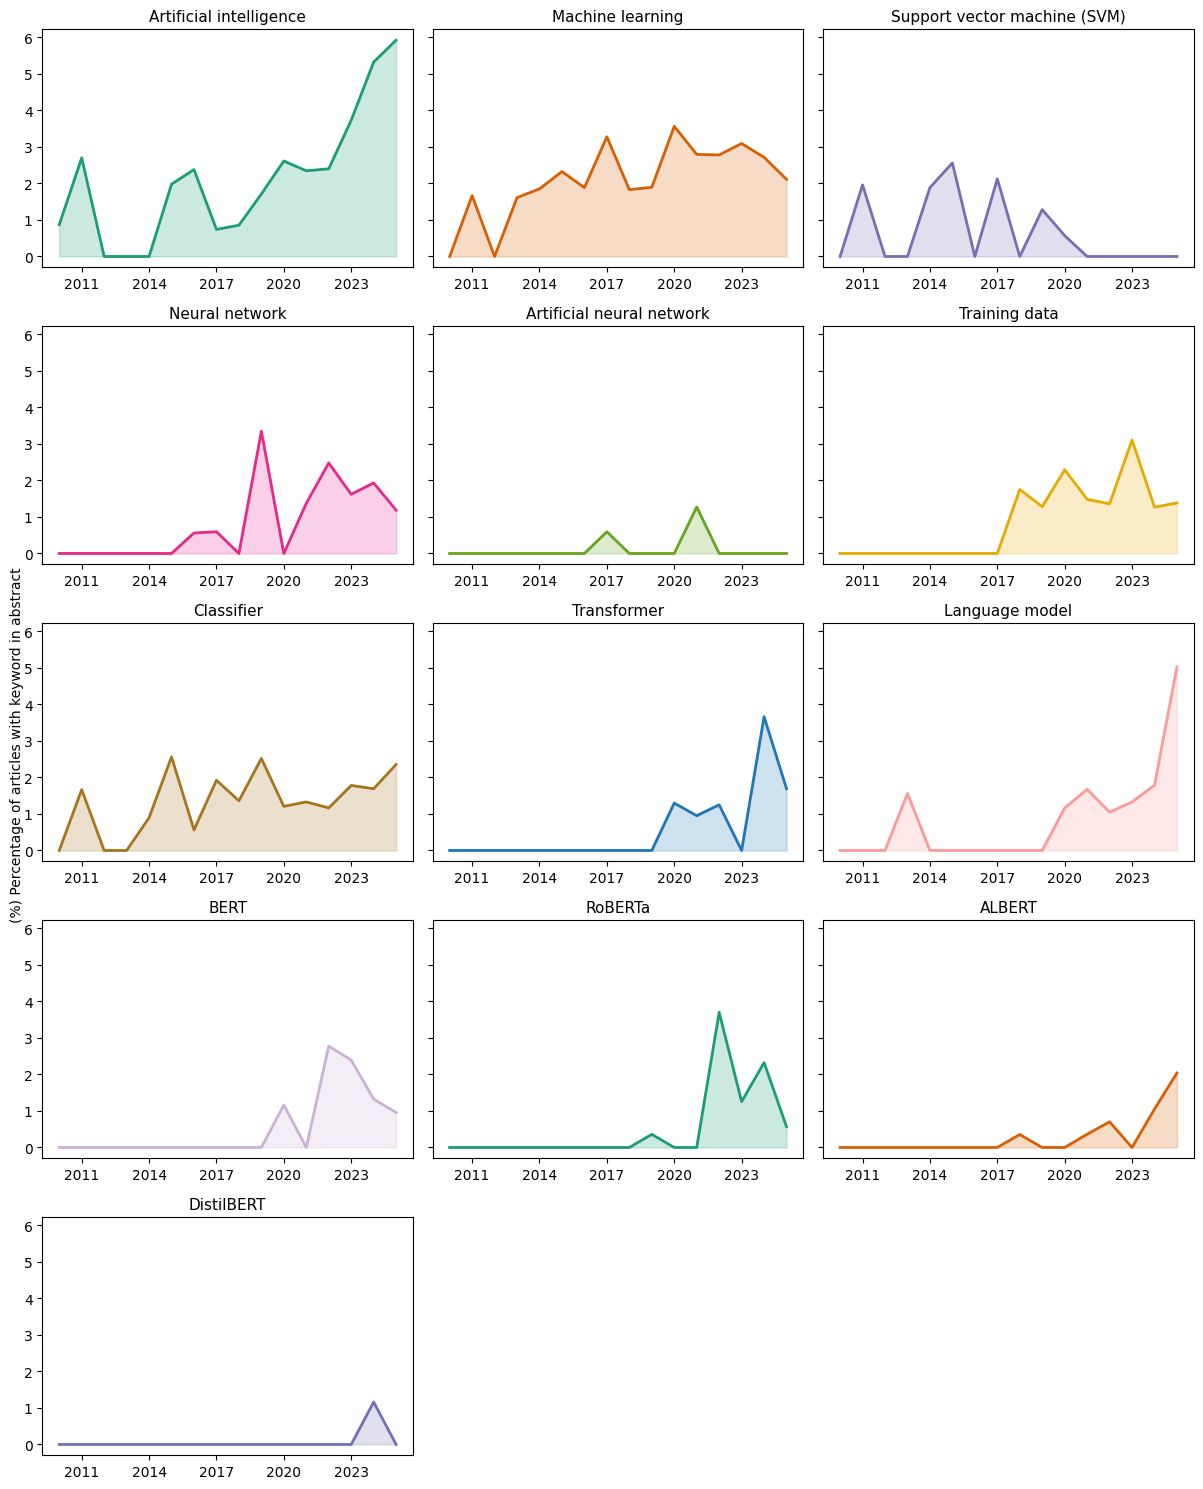

In [ ]:
plot_small_multiples_percentage(
    df_all_jyk=df_all_jyk,
    year_min=2010,
    bert_family=BERT_FAMILY,
    bert_min_year=2018,
    order=order,
    title=None,
    bw=False,
    save_path="keywords_trends_color.png"
)

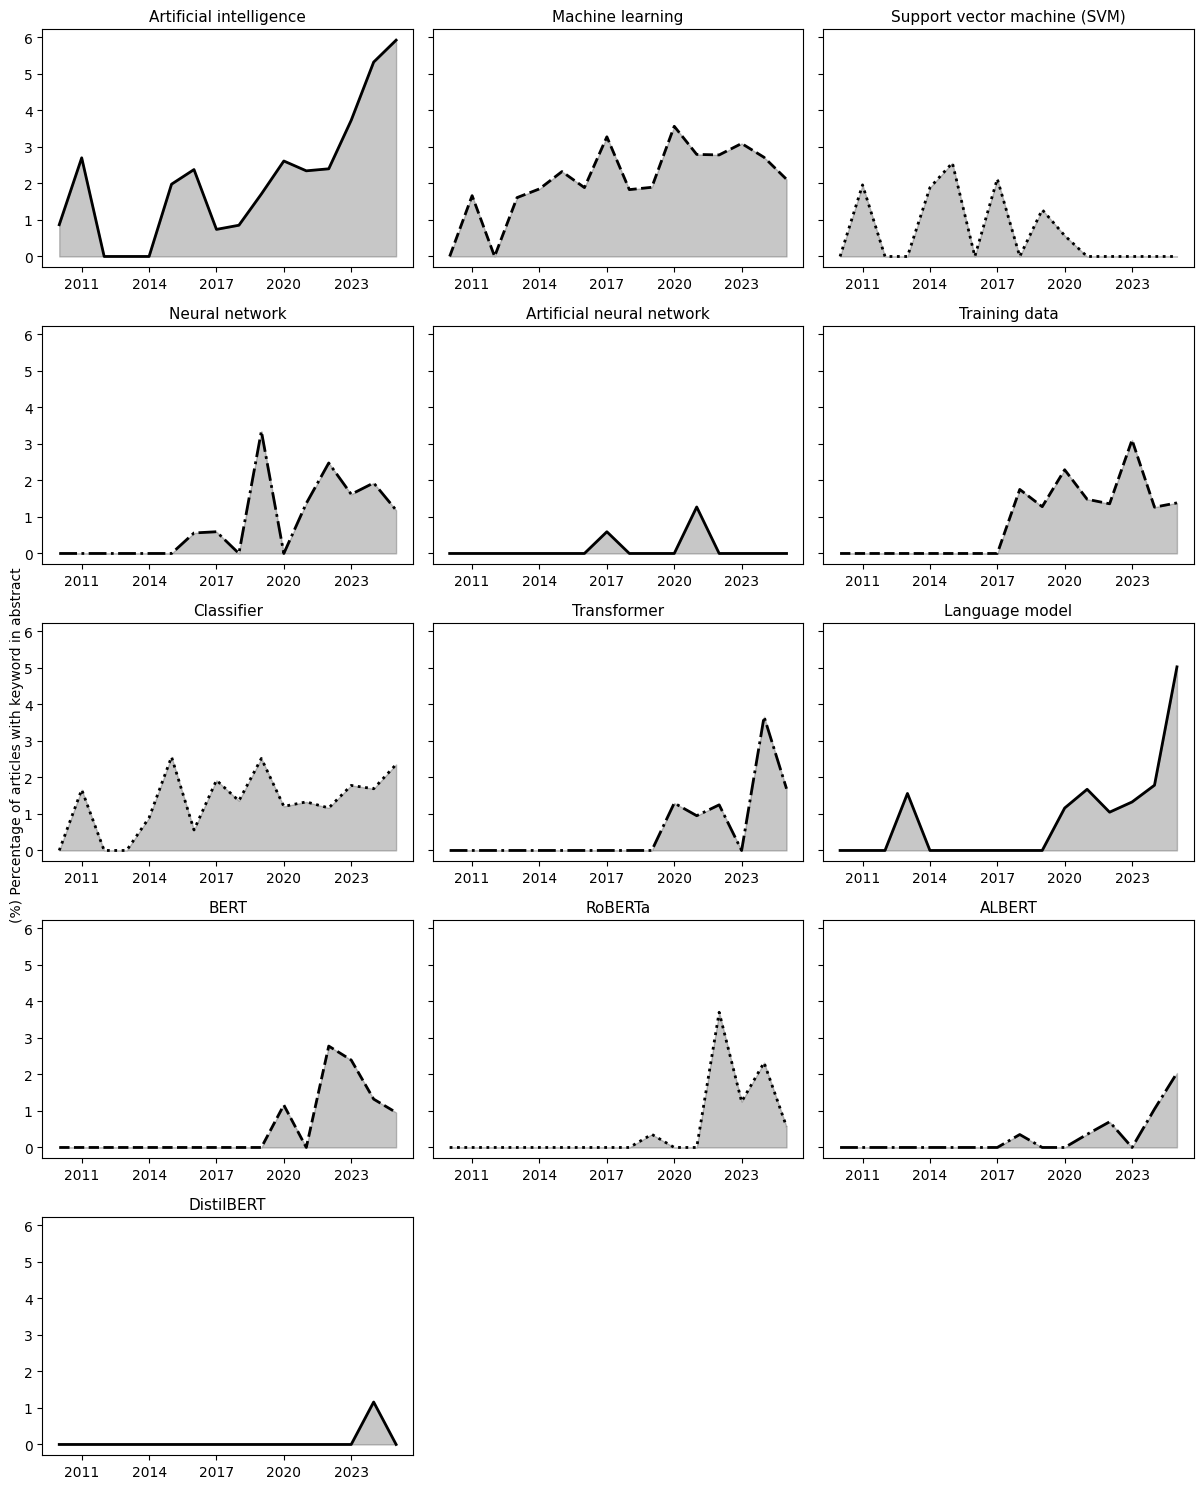

In [ ]:
plot_small_multiples_percentage(
    df_all_jyk=df_all_jyk,
    year_min=2010,
    bert_family=BERT_FAMILY,
    bert_min_year=2018,
    order=order,
    title=None,
    bw=True,
    save_path="keywords_trends_bw.png"
)

### **Interactive Plot**

In [ ]:
def plot_keywords_interactive_area(
    df_all_jyk: pd.DataFrame,
    discipline: str | None = None,
    year_min: int = 2010,
    year_max: int | None = None,
    bert_family: set[str] | None = None,
    bert_min_year: int = 2018,
    order: list[str] | None = None,
    drop_all_zero: bool = True,
    mode: str = "raw",  # "raw" (%) or "index" (first non-zero=100)
    title: str | None = None
):
    df = df_all_jyk.copy()

    # Optional discipline filter
    if discipline is not None and "discipline" in df.columns:
        df = df[df["discipline"] == discipline].copy()

    # BERT-family = 0 before bert_min_year
    if bert_family:
        mask = (df["keyword"].isin(bert_family)) & (df["year"] < bert_min_year)
        df.loc[mask, ["n_articles_with_keyword", "share", "percentage"]] = 0

    # Aggregate across journals: yearly totals per keyword
    yearly = (
        df.groupby(["year", "keyword"], as_index=False)
          .agg(
              n_articles_total=("n_articles_total", "sum"),
              n_articles_with_keyword=("n_articles_with_keyword", "sum")
          )
    )

    if yearly.empty:
        print("No data to plot.")
        return

    if year_max is None:
        year_max = int(yearly["year"].max())

    yearly = yearly[(yearly["year"] >= year_min) & (yearly["year"] <= year_max)].copy()

    yearly["percentage"] = np.divide(
        100.0 * yearly["n_articles_with_keyword"].astype(float),
        yearly["n_articles_total"].astype(float),
        out=np.zeros(len(yearly), dtype=float),
        where=yearly["n_articles_total"].to_numpy() != 0
    )

    # Continuous grid (year × keyword)
    years = list(range(int(year_min), int(year_max) + 1))
    if order is not None:
        keywords = [k for k in order if k in set(yearly["keyword"])]
    else:
        keywords = sorted(yearly["keyword"].unique())

    grid = pd.MultiIndex.from_product([years, keywords], names=["year", "keyword"]).to_frame(index=False)
    yearly = grid.merge(yearly[["year", "keyword", "percentage"]], on=["year", "keyword"], how="left")
    yearly["percentage"] = yearly["percentage"].fillna(0.0)

    # Drop all-zero keywords
    if drop_all_zero:
        keep = yearly.groupby("keyword")["percentage"].max()
        keep = keep[keep > 0].index.tolist()
        yearly = yearly[yearly["keyword"].isin(keep)]
        keywords = [k for k in keywords if k in keep]

    if not keywords:
        print("No keywords to plot after filtering.")
        return

    wide = yearly.pivot(index="year", columns="keyword", values="percentage").reindex(years).fillna(0.0)

    if mode == "index":
        indexed = wide.copy()
        for col in indexed.columns:
            s = indexed[col]
            base = s[s > 0].iloc[0] if (s > 0).any() else 0.0
            indexed[col] = 0.0 if base == 0.0 else (100.0 * s / base)
        plot_data = indexed
        y_label = "Index (first non-zero year = 100)"
    else:
        plot_data = wide
        y_label = "(%) Articles with keyword in abstract"

    # Color palette
    palette = [
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",
        "#e6ab02", "#a6761d", "#1f78b4", "#b2df8a", "#fb9a99",
        "#cab2d6", "#fdbf6f", "#6a3d9a", "#33a02c", "#b15928"
    ]

    def hex_to_rgba(hex_color: str, alpha: float) -> str:
        hex_color = hex_color.lstrip("#")
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        return f"rgba({r},{g},{b},{alpha})"

    # Build figure: one area trace per keyword
    fig = go.Figure()
    for i, kw in enumerate(plot_data.columns):
        c = palette[i % len(palette)]
        fig.add_trace(
            go.Scatter(
                x=plot_data.index,
                y=plot_data[kw],
                mode="lines",
                name=kw,
                line=dict(color=c, width=2.5),
                fill="tozeroy",
                fillcolor=hex_to_rgba(c, 0.22),
                hovertemplate="Year=%{x}<br>Value=%{y:.3f}<extra>"+kw+"</extra>"
            )
        )

    base_title = title or "Keyword prevalence over time"
    if discipline is not None:
        base_title += f" — {discipline}"

    # Buttons: show/hide all (legend already supports multi-select)
    buttons = [
        dict(
            label="Show all",
            method="update",
            args=[{"visible": [True] * len(fig.data)}]
        ),
        dict(
            label="Hide all",
            method="update",
            args=[{"visible": ["legendonly"] * len(fig.data)}]
        ),
    ]

    fig.update_layout(
        title=base_title,
        xaxis_title="Year",
        yaxis_title=y_label,
        template="simple_white",
        hovermode="x unified",
        legend=dict(
            title="Click to toggle (multi-select)",
            orientation="v",
            y=1,
            x=1.02,
            xanchor="left"
        ),
        updatemenus=[dict(
            type="buttons",
            direction="right",
            buttons=buttons,
            x=0.0,
            y=1.12,
            xanchor="left",
            yanchor="top"
        )],
        margin=dict(r=260, t=90)
    )

    fig.update_xaxes(dtick=1, showgrid=True, gridcolor="rgba(0,0,0,0.08)")
    fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.08)")

    fig.show()

In [ ]:
plot_keywords_interactive_area(
    df_all_jyk,
    bert_family={"BERT", "RoBERTa", "ALBERT", "DistilBERT"},
    mode="raw",
    title="AI-related concepts over time"
)

In [ ]:
from google.colab import files
files.download("keywords_trends_color.png")
files.download("keywords_trends_bw.png")
df_all_jyk.to_excel("df_all_jyk.xlsx", index=False)
files.download("df_all_jyk.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>